# **Import libraries**

In [ ]:
#import
import cv2

import os

import shutil

import zipfile

import random

from imutils import paths

from glob import glob

from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.measure import label, regionprops, regionprops_table
from skimage.filters import threshold_otsu
from skimage.morphology import area_closing, area_opening


import warnings
warnings.filterwarnings('ignore')

import pandas as pd

import missingno as msno

from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer

from sklearn.metrics import classification_report

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
# ===
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.model_selection import ShuffleSplit

import numpy as np

In [ ]:
#Connect google drive with colab.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Extract Zip folder from google drive.
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/GP2.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content') #Extracts the files into the /content folder
zip_ref.close()

# **COVID-19 Chest Xray Dataset**

## COVID-19 images

In [ ]:
#Read the metadata.csv
Dataset = pd.read_csv('/content/GP2/Datasets/Imaging Based/Dataset(A)/Metadata/Covid-19 metadata.csv')
Dataset.head()

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,22-Jan-20,"Cho Ray Hospital, Ho Chi Minh City, Vietnam",Covid-19 images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,25-Jan-20,"Cho Ray Hospital, Ho Chi Minh City, Vietnam",Covid-19 images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,27-Jan-20,"Cho Ray Hospital, Ho Chi Minh City, Vietnam",Covid-19 images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,28-Jan-20,"Cho Ray Hospital, Ho Chi Minh City, Vietnam",Covid-19 images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,N,...,25-Jan-20,"Changhua Christian Hospital, Changhua City, Ta...",Covid-19 images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [ ]:
#Check the important features in the metadata
Dataset[['finding','age','sex','view','filename']]

,finding,age,sex,view,filename
0,Pneumonia/Viral/COVID-19,65.0,M,PA,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...
1,Pneumonia/Viral/COVID-19,65.0,M,PA,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...
2,Pneumonia/Viral/COVID-19,65.0,M,PA,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...
3,Pneumonia/Viral/COVID-19,65.0,M,PA,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...
4,Pneumonia/Viral/COVID-19,52.0,F,PA,nejmc2001573_f1a.jpeg
...,...,...,...,...,...
945,Pneumonia,40.0,F,AP,072ecaf8c60a81980abb57150a8016_jumbo-9.jpeg
946,Pneumonia,40.0,F,AP,ff33c406392b968d483174c97eb857_jumbo-9.jpeg
947,Pneumonia,26.0,M,PA,000001-266.jpg
948,Pneumonia,50.0,M,AP,000001-272.jpg


In [ ]:
#Create folder for the dataset images
WORKDATASET_DIR = "/content/GP2/Datasets/Imaging Based/Dataset(A)/workdataset"
if not os.path.exists(WORKDATASET_DIR):
  os.mkdir(WORKDATASET_DIR)
  print("WorkDataset Created")

WorkDataset Created


In [ ]:
#Create folder for the COVID-19 dataset.
COVID_TARGET_DIR = "/content/GP2/Datasets/Imaging Based/Dataset(A)/workdataset/covid-19"
COVID_IMAGE_PATH = "/content/GP2/Datasets/Imaging Based/Dataset(A)/Images/Covid-19"
if not os.path.exists(COVID_TARGET_DIR):
  os.mkdir(COVID_TARGET_DIR)
  print("covid-19 folder created")

covid-19 folder created


In [ ]:
#Transfer COVID-19 images from the metadata to the COVID-19 folder
counter = 0

for(i,row) in Dataset.iterrows():
  if row["finding"] == "Pneumonia/Viral/COVID-19" and row["view"] == "PA":
    filename = row["filename"]
    image_path = os.path.join(COVID_IMAGE_PATH,filename)
    image_copy_path = os.path.join(COVID_TARGET_DIR,filename)
    if os.path.exists(image_path):
      shutil.copy2(image_path,image_copy_path)
      print("moving image",counter)
      counter += 1
    else:
      Dataset = Dataset.drop(i,axis = 0)
        
print("Number of covid-19 images 'PA' View =",counter)

moving image 0
moving image 1
moving image 2
moving image 3
moving image 4
moving image 5
moving image 6
moving image 7
moving image 8
moving image 9
moving image 10
moving image 11
moving image 12
moving image 13
moving image 14
moving image 15
moving image 16
moving image 17
moving image 18
moving image 19
moving image 20
moving image 21
moving image 22
moving image 23
moving image 24
moving image 25
moving image 26
moving image 27
moving image 28
moving image 29
moving image 30
moving image 31
moving image 32
moving image 33
moving image 34
moving image 35
moving image 36
moving image 37
moving image 38
moving image 39
moving image 40
moving image 41
moving image 42
moving image 43
moving image 44
moving image 45
moving image 46
moving image 47
moving image 48
moving image 49
moving image 50
moving image 51
moving image 52
moving image 53
moving image 54
moving image 55
moving image 56
moving image 57
moving image 58
moving image 59
moving image 60
moving image 61
moving image 62
mo

## Normal images

In [ ]:
#Create Normal image folder
NORMAL_IMAGE_PATH = "/content/GP2/Datasets/Imaging Based/Dataset(A)/Images/Normal"
NORMAL_TARGET_DIR = "/content/GP2/Datasets/Imaging Based/Dataset(A)/workdataset/Normal"
if not os.path.exists(NORMAL_TARGET_DIR):
  os.mkdir(NORMAL_TARGET_DIR)
  print("Normal folder created")

Normal folder created


In [ ]:
#Copying 188 random images to match the number of COVID-19 images.
normal_image_names = os.listdir(NORMAL_IMAGE_PATH)
random.seed(5)
random.shuffle(normal_image_names)
for i in range(188):
  image_name = normal_image_names[i]
  image_path = os.path.join(NORMAL_IMAGE_PATH,image_name)
  target_path = os.path.join(NORMAL_TARGET_DIR,image_name)
  shutil.copy2(image_path,target_path)
  print("Copying",i)


Copying 0
Copying 1
Copying 2
Copying 3
Copying 4
Copying 5
Copying 6
Copying 7
Copying 8
Copying 9
Copying 10
Copying 11
Copying 12
Copying 13
Copying 14
Copying 15
Copying 16
Copying 17
Copying 18
Copying 19
Copying 20
Copying 21
Copying 22
Copying 23
Copying 24
Copying 25
Copying 26
Copying 27
Copying 28
Copying 29
Copying 30
Copying 31
Copying 32
Copying 33
Copying 34
Copying 35
Copying 36
Copying 37
Copying 38
Copying 39
Copying 40
Copying 41
Copying 42
Copying 43
Copying 44
Copying 45
Copying 46
Copying 47
Copying 48
Copying 49
Copying 50
Copying 51
Copying 52
Copying 53
Copying 54
Copying 55
Copying 56
Copying 57
Copying 58
Copying 59
Copying 60
Copying 61
Copying 62
Copying 63
Copying 64
Copying 65
Copying 66
Copying 67
Copying 68
Copying 69
Copying 70
Copying 71
Copying 72
Copying 73
Copying 74
Copying 75
Copying 76
Copying 77
Copying 78
Copying 79
Copying 80
Copying 81
Copying 82
Copying 83
Copying 84
Copying 85
Copying 86
Copying 87
Copying 88
Copying 89
Copying 90
Copying 9

## Preprocessing the dataset

In [ ]:
#Create function that convert images into numerical and return dataframe
def get_properties(name):
  array = []
  print(name)
  if name == "COVID-19":
    filepaths = "/content/GP2/Datasets/Imaging Based/Dataset(A)/workdataset/covid-19"
  if name == "Normal":
    filepaths = "/content/GP2/Datasets/Imaging Based/Dataset(A)/workdataset/Normal"
 

  print(filepaths)
  CATEGORIES = ['Covid-19','Normal']
  properties = ['area','convex_area','bbox_area','major_axis_length', 'minor_axis_length', 'perimeter', 'equivalent_diameter', 'mean_intensity', 'solidity', 'eccentricity']
  counter = 1
  dataframe = pd.DataFrame(columns=properties)
  for img in os.listdir(filepaths):
      print(counter)
      image = cv2.imread(os.path.join(filepaths,img))
      image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (512,512))
      image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
      thresh ,binarized_image = cv2.threshold(image_gray, 128, 255,cv2.THRESH_BINARY)

      closed = area_closing(binarized_image)
      opened = area_opening(closed)

      label_image = label(opened)
      #label_image = label(binarized_image)
      #regions = regionprops(label_image)
      data = pd.DataFrame(regionprops_table(label_image, image_gray,properties=properties))
      data = data[(data.index!=0) & (data.area>100)]
      dataframe = pd.concat([dataframe, data])
      counter += 1
      array.append([1,label_image])
  return dataframe

In [ ]:
#Using the function to convert the COVID-19 images into dataframe
covid = get_properties("COVID-19")
covid['Finding'] = 'Covid-19'

COVID-19
/content/GP2/Datasets/Imaging Based/Dataset(A)/workdataset/covid-19
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188


In [ ]:
#Using the function to convert the Normal images into dataframe
normal = get_properties('Normal')
normal['Finding'] = 'Normal'

Normal
/content/GP2/Datasets/Imaging Based/Dataset(A)/workdataset/Normal
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188


In [ ]:
#Create new dataframe that combine covid and normal
CombineDataset = pd.concat([covid,normal])

In [ ]:
#Create final dataframe to expand the features from 10 to 16
CombineDataset['ratio_length'] = (CombineDataset['major_axis_length'] / CombineDataset['minor_axis_length'])
CombineDataset['perimeter_ratio_major'] = (CombineDataset['perimeter'] / CombineDataset['major_axis_length'])
CombineDataset['perimeter_ratio_minor'] = (CombineDataset['perimeter'] / CombineDataset['minor_axis_length'])
CombineDataset['area_ratio_convex'] = CombineDataset['area'] / CombineDataset['convex_area']
CombineDataset['area_ratio_bbox'] = CombineDataset['area'] / CombineDataset['bbox_area']
CombineDataset['peri_over_dia'] = CombineDataset['perimeter'] / CombineDataset['equivalent_diameter']
Final_dataframe = CombineDataset[CombineDataset.drop('Finding', axis=1).columns].astype(float)
Final_dataframe= Final_dataframe.replace(np.inf, 0)
Final_dataframe['Finding'] = CombineDataset['Finding']

In [ ]:
ExcelFile = pd.ExcelWriter('COVID-19 Chest Xray Dataset.xlsx')
# write dataframe to excel
Final_dataframe.to_excel(ExcelFile)
# save the excel  
ExcelFile.save()
print('DataFrame is written successfully to Excel File.')

DataFrame is written successfully to Excel File.


# **Testing the Dataset**

## #1 Load Dataset

In [ ]:
url_utf = '/content/COVID-19 Chest Xray Dataset.csv'
data = pd.read_csv(url_utf, encoding = "utf-8")

## #2 Preprocessing

In [ ]:
#Remove the Unnamed: 0 feature
print(data.nunique())
data = data.drop('Unnamed: 0', axis=1)
print(data.shape)

area                      723
convex_area               879
bbox_area                 767
major_axis_length        1416
minor_axis_length        1415
perimeter                1322
equivalent_diameter       723
mean_intensity           1412
solidity                 1359
eccentricity             1415
ratio_length             1415
perimeter_ratio_major    1416
perimeter_ratio_minor    1415
area_ratio_convex        1359
area_ratio_bbox          1323
peri_over_dia            1413
Finding                     2
dtype: int64
(1416, 17)


In [ ]:
#Check if there a missing data
data.isna().mean().round(4) * 100

area                     0.0
convex_area              0.0
bbox_area                0.0
major_axis_length        0.0
minor_axis_length        0.0
perimeter                0.0
equivalent_diameter      0.0
mean_intensity           0.0
solidity                 0.0
eccentricity             0.0
ratio_length             0.0
perimeter_ratio_major    0.0
perimeter_ratio_minor    0.0
area_ratio_convex        0.0
area_ratio_bbox          0.0
peri_over_dia            0.0
Finding                  0.0
dtype: float64

In [ ]:
#Convert the target value into 1 and 0
print(data.groupby('Finding').size())
data.loc[data["Finding"] == "Covid-19", "Finding"] = 1
data.loc[data["Finding"] == "Normal", "Finding"] = 0
print(data.groupby('Finding').size())

Finding
Covid-19    652
Normal      764
dtype: int64
Finding
0    764
1    652
dtype: int64


In [ ]:
# split all the data
X = data.drop('Finding', axis=1)
y = data['Finding']


# Split the data with high collareation.
''' X = data.drop(['Finding', 'convex_area', 'bbox_area', 'major_axis_length',
               'minor_axis_length', 'perimeter', 'equivalent_diameter',
               'area_ratio_convex', 'perimeter_ratio_minor'], axis=1)
y = data['Finding']  '''
#convert the the target variable from unknow object into int
y=y.astype('int')

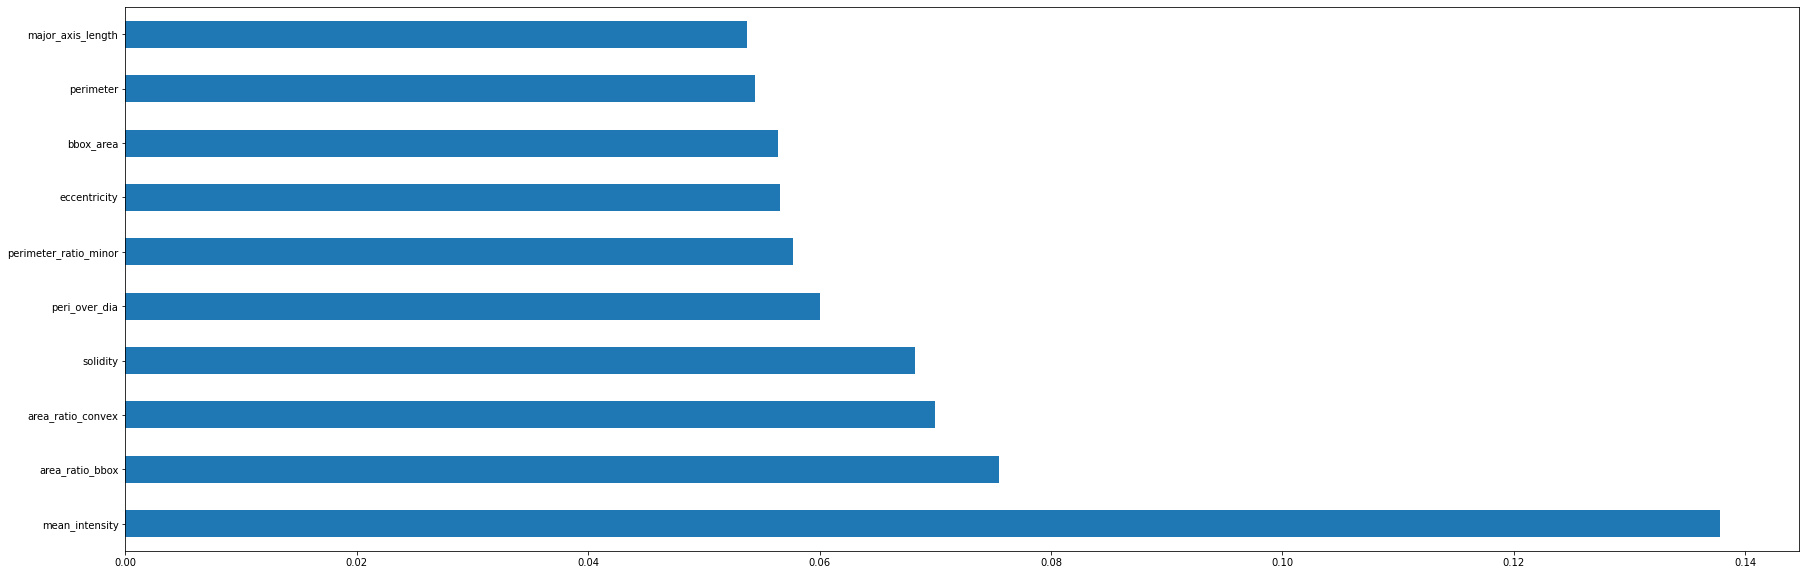

In [ ]:
#use inbuilt class feature_importances of tree based classifiers
model = ExtraTreesClassifier()
model.fit(X, y)

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(figsize=(30, 10), kind='barh')
plt.show()

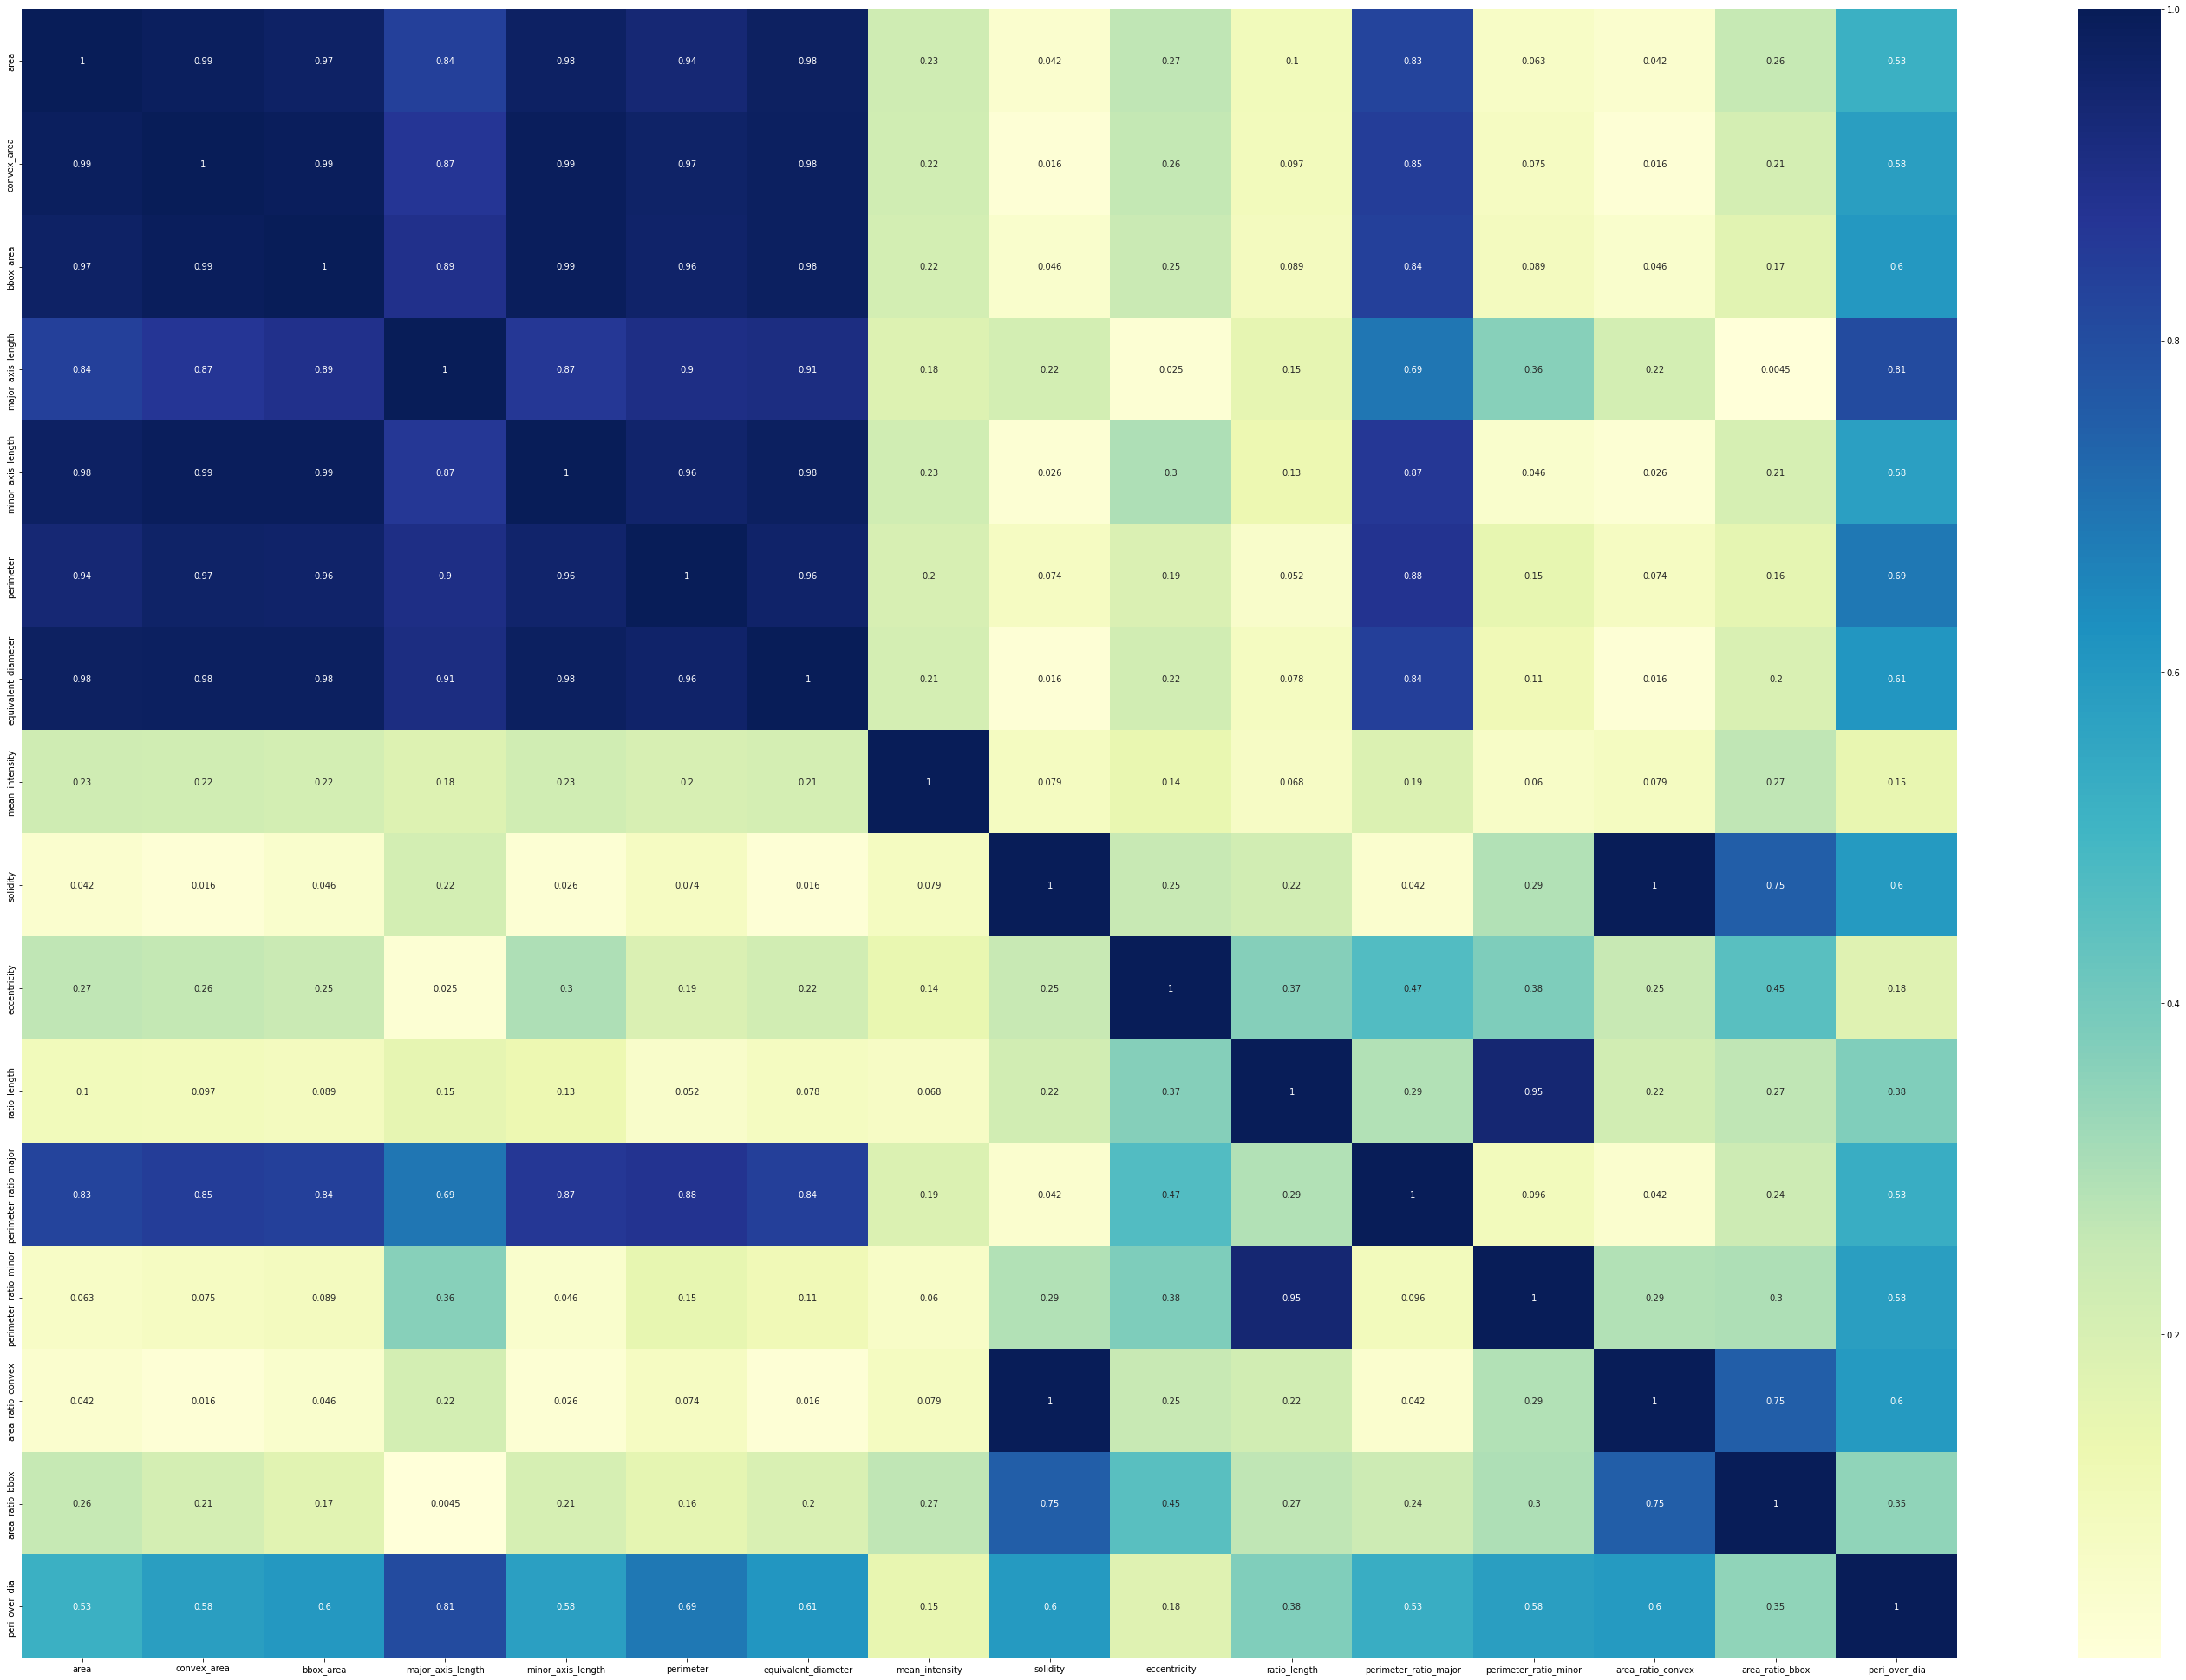

In [ ]:
#Heatmap to check the collareation between the features
plt.figure(figsize = (50,35))
corr = data.corr().abs()
hm = sns.heatmap(corr, cmap="YlGnBu", annot=True)
plt.show() 

In [ ]:
# Standraize data.
standardize_scaler = StandardScaler()
standardizedX = standardize_scaler.fit(X).transform(X)
X = pd.DataFrame(standardizedX)

## #3 Model

In [ ]:
temp = pd.DataFrame(y)
print(temp.groupby('Finding').size())
print(X.shape)

Finding
0    764
1    652
dtype: int64
(1416, 16)


In [ ]:
model_list = [LogisticRegression(random_state=111), svm.SVC(random_state=111), KNeighborsClassifier(n_neighbors=3), 
         GaussianNB(), DecisionTreeClassifier(random_state=111), RandomForestClassifier(random_state=111), 
         xgb.XGBClassifier(random_state=111)]

modelName_list = ['LR', 'SVM', 'KNN', 'NB', 'DT', 'RF', 'XGB']

In [ ]:
cross_validator = ShuffleSplit(n_splits=10, random_state=111)
for i in range(7):
  model = model_list[i]
  score_f1 = cross_val_score(model, X, y, scoring='f1_macro', cv=cross_validator).mean().round(2)
  score_recall = cross_val_score(model, X, y, scoring='recall_macro', cv=cross_validator).mean().round(2)
  score_precision = cross_val_score(model, X, y, scoring='precision_macro', cv=cross_validator).mean().round(2)
  print('The [F1-Score] of {} is {}:'.format(modelName_list[i], score_f1))
  print('The [Recall] of {} is: {}'.format(modelName_list[i], score_recall)) 
  print('The [Precision] of {} is: {}'.format(modelName_list[i], score_precision))
  print()

The [F1-Score] of LR is 0.64:
The [Recall] of LR is: 0.65
The [Precision] of LR is: 0.65

The [F1-Score] of SVM is 0.71:
The [Recall] of SVM is: 0.71
The [Precision] of SVM is: 0.71

The [F1-Score] of KNN is 0.67:
The [Recall] of KNN is: 0.67
The [Precision] of KNN is: 0.67

The [F1-Score] of NB is 0.6:
The [Recall] of NB is: 0.61
The [Precision] of NB is: 0.62

The [F1-Score] of DT is 0.67:
The [Recall] of DT is: 0.67
The [Precision] of DT is: 0.67

The [F1-Score] of RF is 0.72:
The [Recall] of RF is: 0.72
The [Precision] of RF is: 0.72

The [F1-Score] of XGB is 0.7:
The [Recall] of XGB is: 0.7
The [Precision] of XGB is: 0.7

